In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [2]:
df = pd.read_csv("data/Stocks/amzn.us.txt")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     5153 non-null   object 
 1   Open     5153 non-null   float64
 2   High     5153 non-null   float64
 3   Low      5153 non-null   float64
 4   Close    5153 non-null   float64
 5   Volume   5153 non-null   int64  
 6   OpenInt  5153 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 281.9+ KB


In [5]:
df = df.drop("OpenInt", axis = 1)

In [6]:
df.describe()

,Open,High,Low,Close,Volume
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03
mean,181.747357,183.880652,179.466684,181.769343,7.837325e+06
std,239.611052,241.226109,237.638139,239.548391,7.594745e+06
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00
25%,35.500000,36.130000,35.000000,35.550000,3.779449e+06
50%,70.900000,72.750000,69.020000,70.700000,5.902992e+06
75%,242.850000,245.770000,240.670000,243.880000,8.888949e+06
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08


In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df["Week"] = pd.to_timedelta(df["Date"].dt.weekday, unit = "D")
df["Week"] = df["Date"] - df["Week"]
df["Month"] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-01'))
df["Month_Num"] = df["Date"].dt.month.astype("object")
df["Year"] = pd.to_datetime(df["Date"].dt.strftime('%Y-01-01'))

In [8]:
def ma_calculate(data, window = 1, min_periods = 1, thresholds = 2):
    mean = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).mean())
    std = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).std())
    upper_band= mean + thresholds * std
    lower_band= mean - thresholds * std
    anomaly_index = np.where((data > upper_band) | (data < lower_band))[0]
    return mean, std, upper_band, lower_band, anomaly_index

In [9]:
data_graph = pd.DataFrame(np.log10(df.groupby("Week").sum()["Volume"]))
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 10)

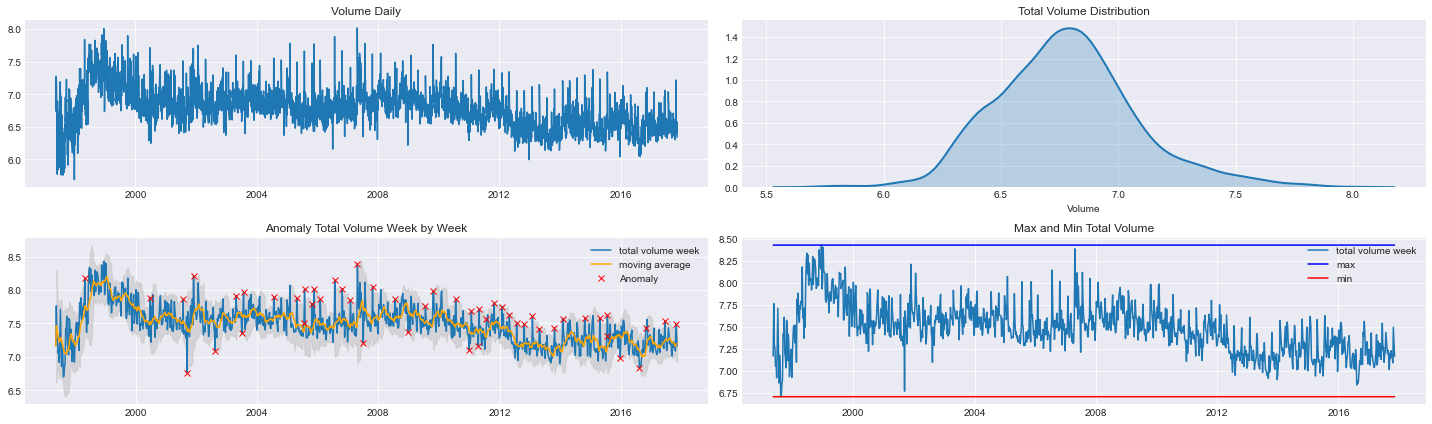

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (20, 6))
ax[0, 0].plot(df[df["Volume"] != 0]["Date"], np.log10(df[df["Volume"] != 0]["Volume"]))
sns.distplot(np.log10(df[df["Volume"] != 0]["Volume"]), hist = False, kde_kws = {'shade': True, 'linewidth': 2}, ax = ax[0, 1])
ax[1, 0].plot(data_graph.index, data_graph["Volume"], label = "total volume week")
ax[1, 0].plot(mean.index, mean["Volume"], color = "orange", label = "moving average")
ax[1, 0].fill_between(x = mean.index, y1 = lower_band["Volume"], y2 = upper_band["Volume"], color = "silver", alpha = 0.5)
ax[1, 0].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
ax[1, 1].plot(data_graph.index, data_graph["Volume"], label = "total volume week")
ax[1, 1].plot(data_graph.index, [data_graph["Volume"].max()] * len(data_graph.index), color = "blue", label = "max")
ax[1, 1].plot(data_graph.index, [data_graph["Volume"].min()] * len(data_graph.index), color = "red", label = "min")
ax[0, 0].set_title("Volume Daily")
ax[0, 1].set_title("Total Volume Distribution")
ax[1, 0].set_title("Anomaly Total Volume Week by Week")
ax[1, 1].set_title("Max and Min Total Volume")
ax[1, 0].legend()
ax[1, 1].legend(loc = 1)
plt.tight_layout()
plt.show()

In [11]:
data_graph = pd.DataFrame(df.groupby("Week").mean()["Open"])
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 10)

df["zdata"] = (df["Open"] - df["Open"].rolling(window = 10, min_periods = 1).mean()) / df["Open"].rolling(window = 10, min_periods = 1).std()
df["zpdata"] = df["zdata"] - df["zdata"].shift(12)

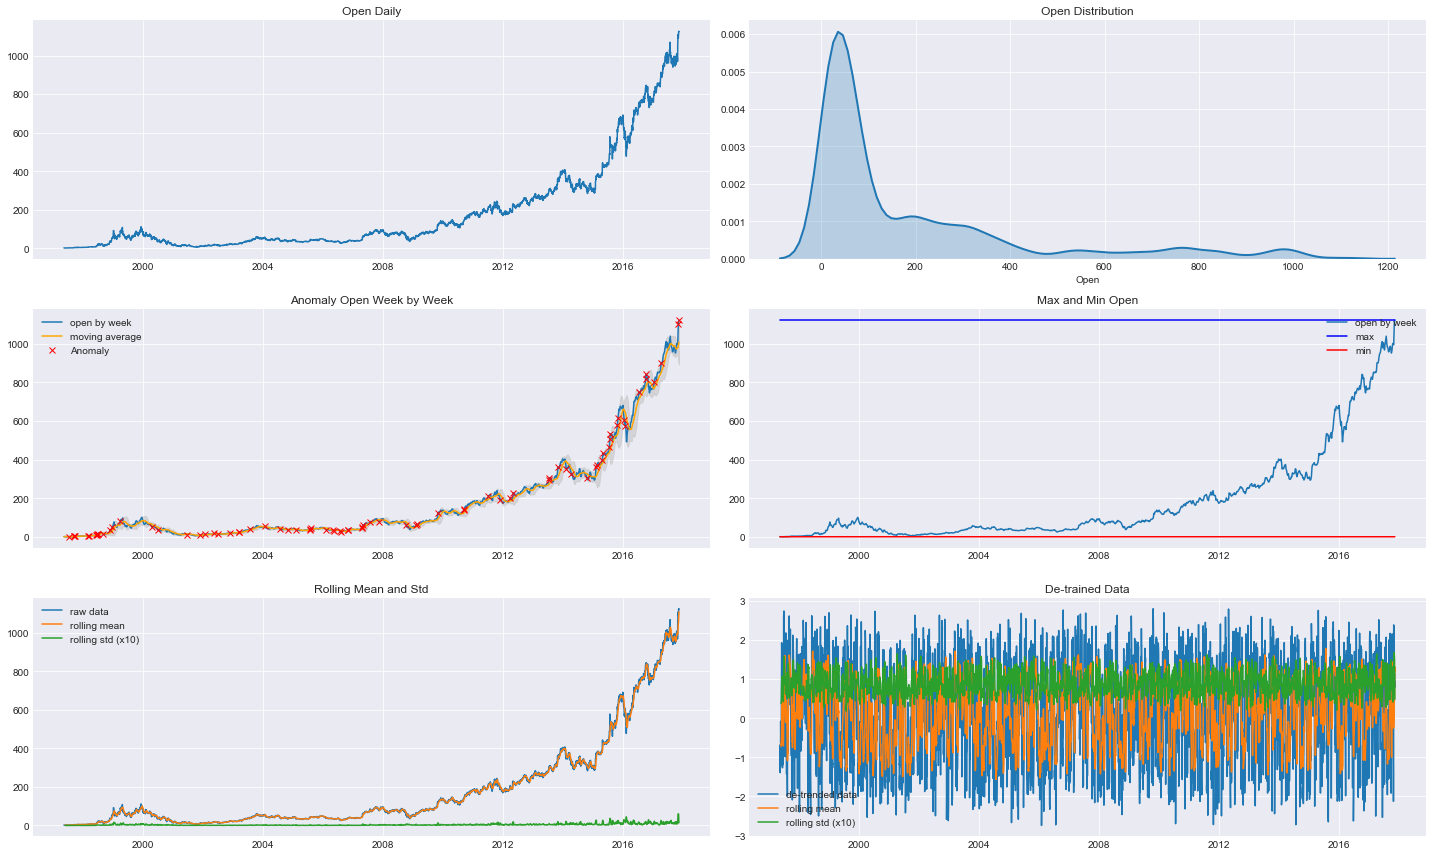

In [12]:
fig, ax = plt.subplots(3, 2, figsize = (20, 12))
ax[0, 0].plot(df["Date"], df["Open"])
sns.distplot(df["Open"], hist = False, kde_kws = {'shade': True, 'linewidth': 2}, ax = ax[0, 1])
ax[1, 0].plot(data_graph.index, data_graph["Open"], label = "open by week")
ax[1, 0].plot(mean.index, mean["Open"], color = "orange", label = "moving average")
ax[1, 0].fill_between(x = mean.index, y1 = lower_band["Open"], y2 = upper_band["Open"], color = "silver", alpha = 0.5)
ax[1, 0].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
ax[1, 1].plot(data_graph.index, data_graph["Open"], label = "open by week")
ax[1, 1].plot(data_graph.index, [data_graph["Open"].max()] * len(data_graph.index), color = "blue", label = "max")
ax[1, 1].plot(data_graph.index, [data_graph["Open"].min()] * len(data_graph.index), color = "red", label = "min")
ax[2, 0].plot(df["Date"], df["Open"], label='raw data')
ax[2, 0].plot(df["Date"], df["Open"].rolling(window=10).mean(), label="rolling mean")
ax[2, 0].plot(df["Date"], df["Open"].rolling(window=10).std(), label="rolling std (x10)")
ax[2, 1].plot(df["Date"], df["zdata"], label="de-trended data")
ax[2, 1].plot(df["Date"], df["zdata"].rolling(window=10).mean(), label="rolling mean")
ax[2, 1].plot(df["Date"], df["zdata"].rolling(window=10).std(), label="rolling std (x10)")
ax[0, 0].set_title("Open Daily")
ax[0, 1].set_title("Open Distribution")
ax[1, 0].set_title("Anomaly Open Week by Week")
ax[1, 1].set_title("Max and Min Open")
ax[2, 0].set_title("Rolling Mean and Std")
ax[2, 1].set_title("De-trained Data")
ax[1, 0].legend()
ax[1, 1].legend(loc = 1)
ax[2, 0].legend()
ax[2, 1].legend()
plt.tight_layout()
plt.show()

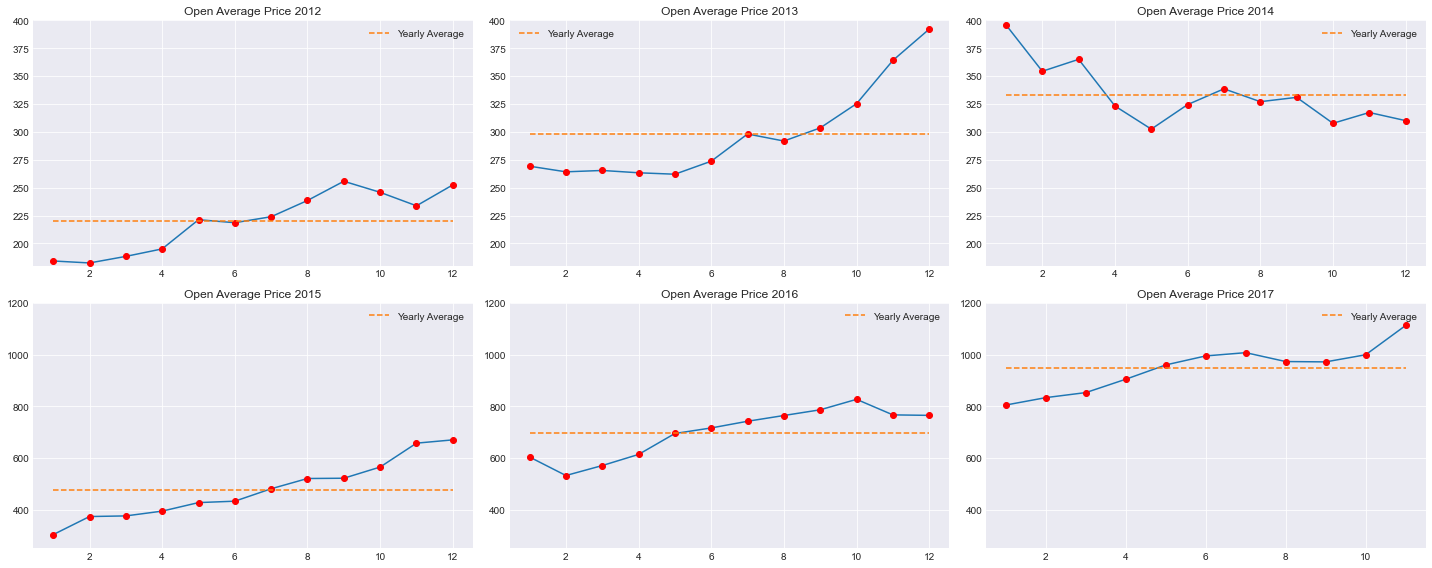

In [13]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
years = ["2012", "2013", "2014", "2015", "2016", "2017"]
for row in range(2):
    for col in range(3):
        data_graph = df[df["Year"] == years[(row * 3) + col]].groupby("Month_Num").mean().reset_index()
        ax[row, col].plot(data_graph["Month_Num"], data_graph["Open"], marker = "o", markerfacecolor = "red", markeredgecolor = "red")
        ax[row, col].plot(data_graph["Month_Num"], [data_graph["Open"].mean()] * len(data_graph["Month_Num"]), ls = "--", label = "Yearly Average")
        ax[row, col].set_title("Open Average Price " + years[(row * 3) + col])
        ax[row, col].legend()
        ax[0, col].set_ylim(180, 400)
        ax[1, col].set_ylim(250, 1200)
plt.tight_layout()
plt.show()
fig.savefig('data_average_open_price.png')

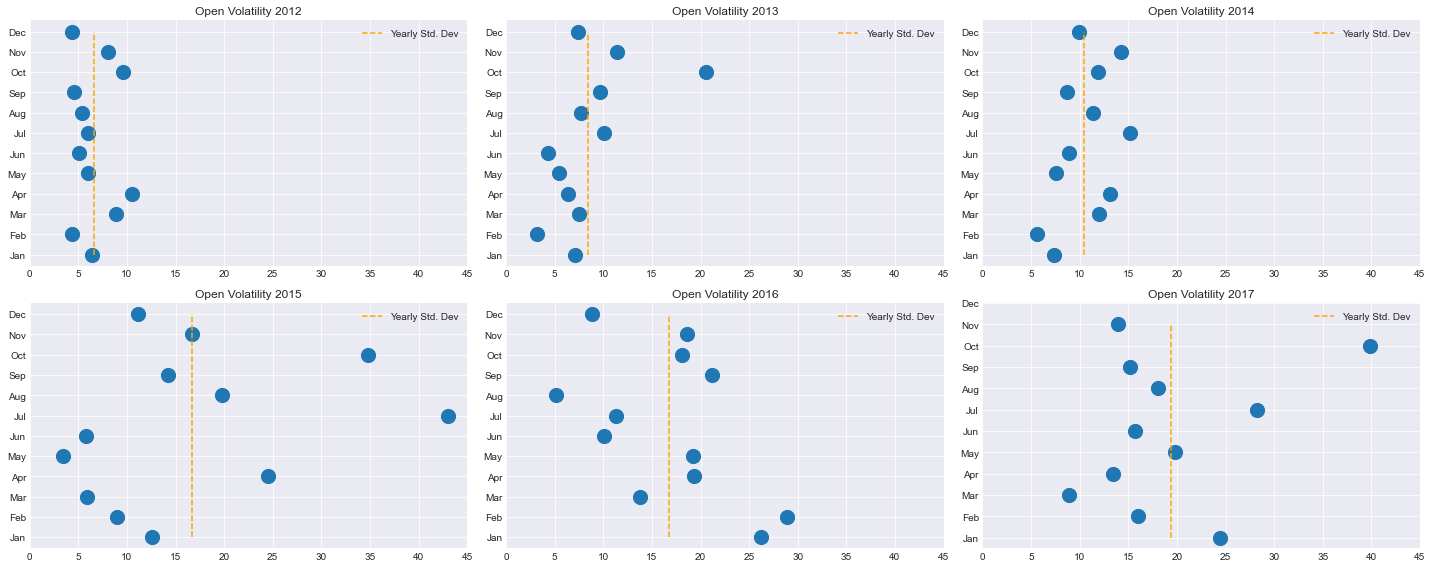

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
years = ["2012", "2013", "2014", "2015", "2016", "2017"]
for row in range(2):
    for col in range(3):
        data_graph = df[df["Year"] == years[(row * 3) + col]].groupby("Month_Num").std().reset_index()
        ax[row, col].scatter(data_graph["Open"], data_graph["Month_Num"], s = 200)
        ax[row, col].plot([data_graph["Open"].mean()] * len(data_graph["Month_Num"]), data_graph["Month_Num"], color = "orange", ls = "--", label = "Yearly Std. Dev")
        ax[row, col].set_title("Open Volatility " + years[(row * 3) + col])
        ax[row, col].legend()
        ax[row, col].set_xlim(0, 45)
plt.setp(ax, yticks = sorted(df["Month_Num"].unique()),
         yticklabels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()

In [15]:
diff_mean = df[df["Date"] >= "2011-01-01"].groupby(["Month_Num", "Year"]).mean().reset_index()
diff_mean["Diff_Open"] = diff_mean["Open"].pct_change()

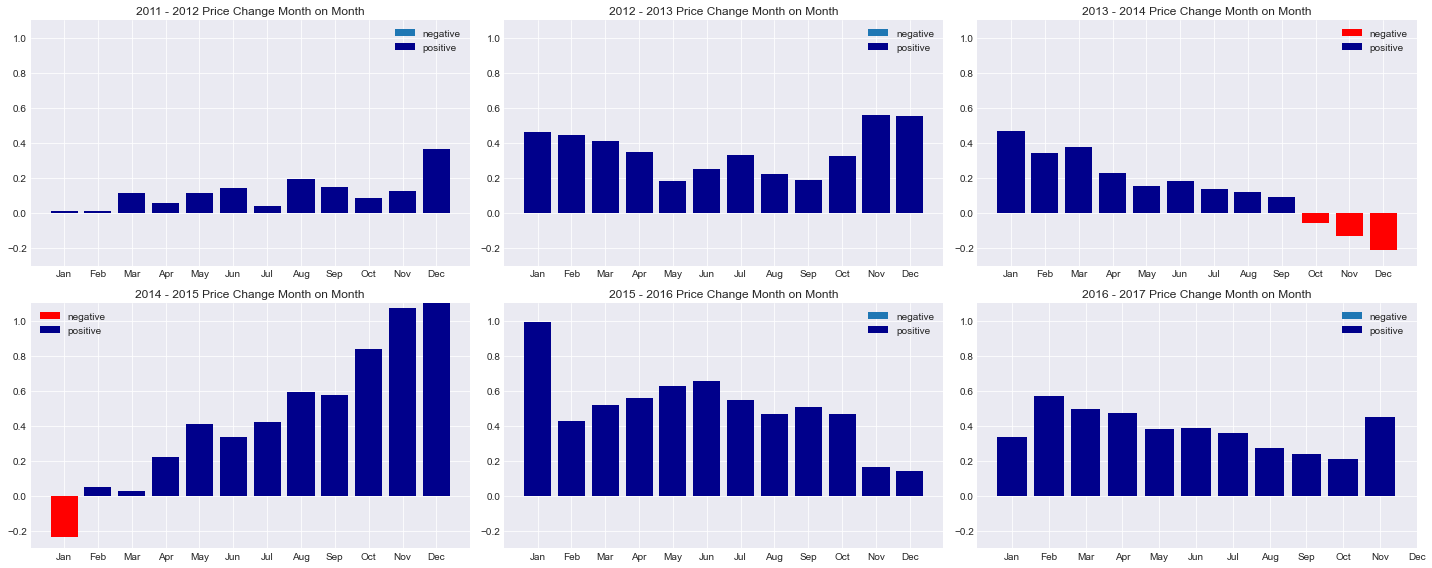

In [16]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
for row in range(2):
    for col in range(3):
        ax[row, col].bar("Month_Num", "Diff_Open",
            data = diff_mean[(diff_mean["Year"] == str(2012 + (row * 3 + col))) & (diff_mean["Diff_Open"] < 0)], color = "red", label = "negative")
        ax[row, col].bar("Month_Num", "Diff_Open",
            data = diff_mean[(diff_mean["Year"] == str(2012 + (row * 3 + col))) & (diff_mean["Diff_Open"] >= 0)], color = "darkblue", label = "positive")
        ax[row, col].legend()
        ax[row, col].set_title(str(2011 + (row * 3 + col)) + " - " + str(2012 + (row * 3 + col)) + " Price Change Month on Month")
        ax[row, col].set_ylim(-0.3, 1.1)
        plt.setp(ax[row, col], xticks = diff_mean["Month_Num"].unique(),
                 xticklabels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()

## **TIME SERIES FORECAST**

In [17]:
ts_pred = df.copy()
ts_pred["Next"] = ts_pred["Open"].shift()
ts_pred = ts_pred.dropna()

In [18]:
X = ts_pred["Open"].values
y = ts_pred["Next"].values

In [19]:
train_size = int(len(X) * 0.8)

In [20]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [21]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
lr.coef_

array([0.99841198])

In [25]:
y_pred = lr.predict(X_test)

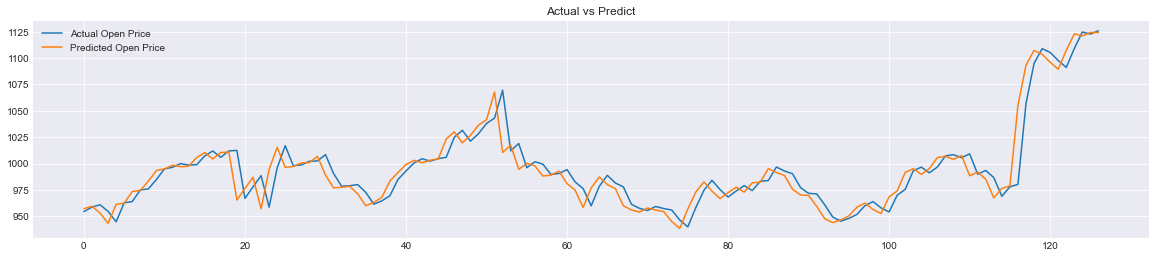

In [26]:
plt.figure(figsize = (20, 4))
plt.plot(y_test[-127:], label = "Actual Open Price")
plt.plot(y_pred[-127:], label = "Predicted Open Price")
plt.title("Actual vs Predict")
plt.legend()
plt.show()

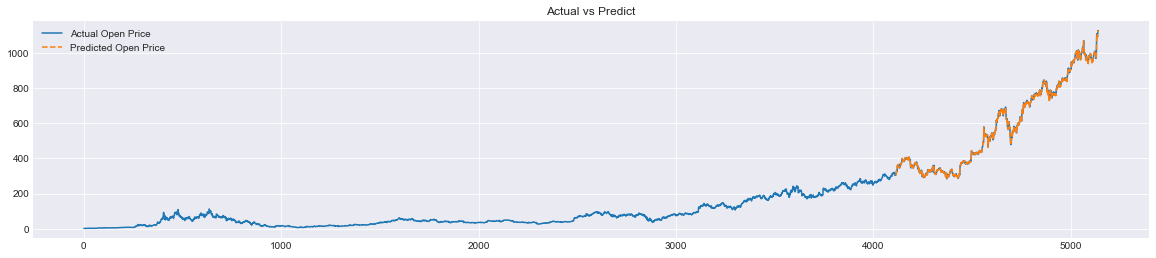

In [27]:
plt.figure(figsize = (20, 4))
plt.plot(np.append(y_train, y_test), label = "Actual Open Price")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Predicted Open Price")
plt.title("Actual vs Predict")
plt.legend()
plt.show()

In [28]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

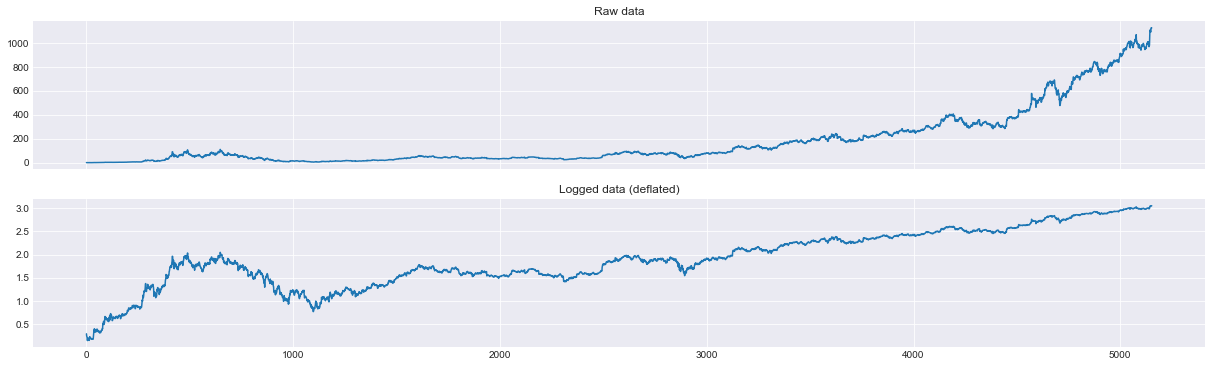

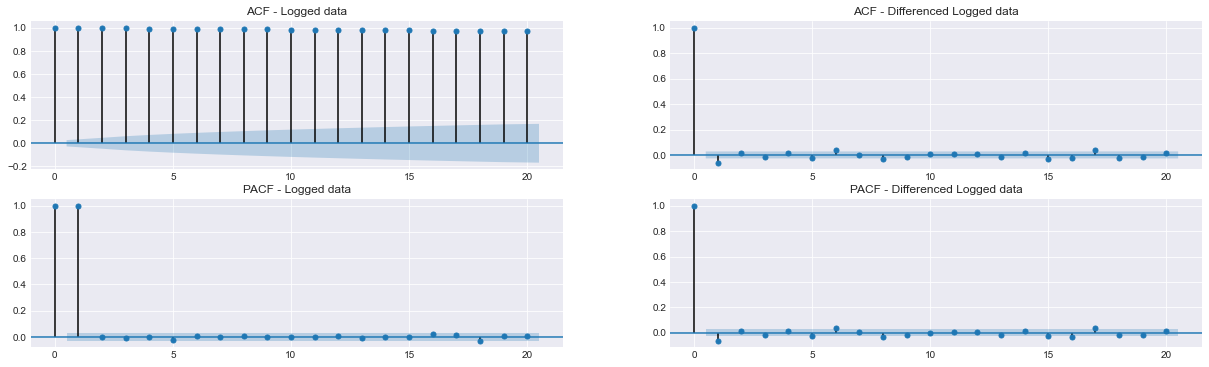

In [29]:
fig, ax = plt.subplots(2, sharex=True, figsize=(21,6))
ax[0].plot(df["Open"].values);
ax[0].set_title("Raw data");
ax[1].plot(np.log10(df["Open"].values));
ax[1].set_title("Logged data (deflated)");
# ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(21,6))
first_diff = (np.log10(df["Open"]) - np.log10(df["Open"]).shift()).dropna()
ax[0, 0] = plot_acf(np.log10(df["Open"]), ax = ax[0, 0], lags = 20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log10(df["Open"]), ax = ax[1, 0], lags = 20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax = ax[0, 1], lags = 20, title = "ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax = ax[1, 1], lags = 20, title = "PACF - Differenced Logged data")

                              ARMA Model Results                              
Dep. Variable:                   Open   No. Observations:                 5153
Model:                     ARMA(0, 0)   Log Likelihood               -4711.627
Method:                           css   S.D. of innovations              0.604
Date:                Thu, 27 Aug 2020   AIC                           9427.255
Time:                        22:44:20   BIC                           9440.350
Sample:                             0   HQIC                          9431.837
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8972      0.008    225.573      0.000       1.881       1.914
                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observat

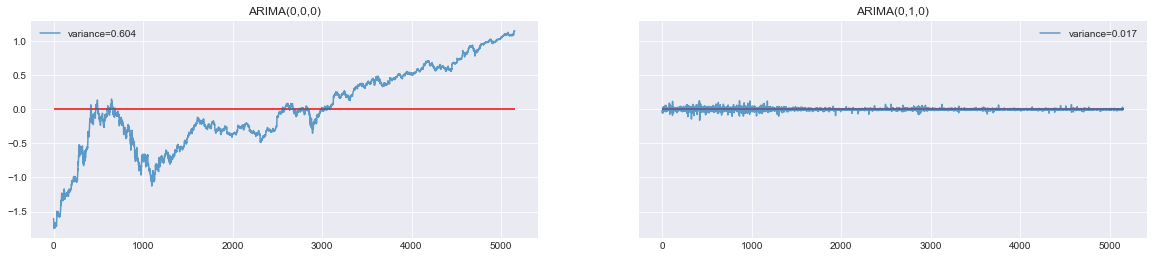

In [30]:
model = ARIMA(np.log10(df["Open"]).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log10(df["Open"]).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (20, 4))
ax[0].plot(res_000.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin = 0, xmax = len(res_000.resid.values), color = 'r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin = 0, xmax = len(res_010.resid.values), color = 'r')
ax[1].set_title("ARIMA(0,1,0)")
ax[1].legend()
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 5152
Model:                 ARIMA(0, 1, 0)   Log Likelihood               13590.469
Method:                           css   S.D. of innovations              0.017
Date:                Thu, 27 Aug 2020   AIC                         -27176.939
Time:                        22:44:22   BIC                         -27163.844
Sample:                             1   HQIC                        -27172.356
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.220      0.026    6.27e-05       0.001
                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observat

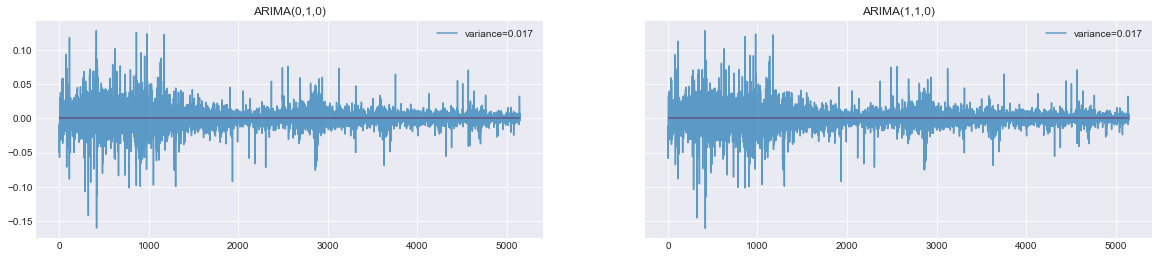

In [31]:
model = ARIMA(np.log10(df["Open"]).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

model = ARIMA(np.log10(df["Open"]).dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (20, 4))
ax[0].plot(res_010.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[0].hlines(0, xmin = 0, xmax = len(res_010.resid.values), color = 'r')
ax[0].set_title("ARIMA(0,1,0)")
ax[0].legend()
ax[1].plot(res_110.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_110.resid.values)))
ax[1].hlines(0, xmin = 0, xmax = len(res_110.resid.values), color = 'r')
ax[1].set_title("ARIMA(1,1,0)")
ax[1].legend()
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 5152
Model:                 ARIMA(1, 1, 0)   Log Likelihood               13600.049
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 27 Aug 2020   AIC                         -27194.097
Time:                        22:44:24   BIC                         -27174.456
Sample:                             1   HQIC                        -27187.224
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0005      0.000      2.362      0.018    9.12e-05       0.001
ar.L1.D.Open    -0.0610      0.014     -4.381      0.000      -0.088      -0.034
                                    Roots   

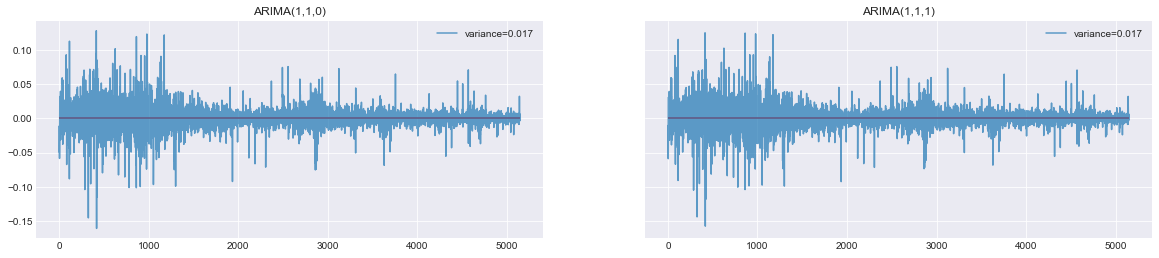

In [32]:
model = ARIMA(np.log10(df["Open"]).dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

model = ARIMA(np.log10(df["Open"]).dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (20, 4))
ax[0].plot(res_110.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_110.resid.values)))
ax[0].hlines(0, xmin = 0, xmax = len(res_110.resid.values), color = 'r')
ax[0].set_title("ARIMA(1,1,0)")
ax[0].legend()
ax[1].plot(res_111.resid.values, alpha = 0.7, label = 'variance={:.3f}'.format(np.std(res_111.resid.values)))
ax[1].hlines(0, xmin = 0, xmax = len(res_111.resid.values), color = 'r')
ax[1].set_title("ARIMA(1,1,1)")
ax[1].legend()
plt.show()

In [33]:
model = ARIMA(y_test, order = (1, 1, 1))

In [34]:
model_fit = model.fit(disp = 5)

In [35]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1027
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3873.341
Method:                       css-mle   S.D. of innovations             10.513
Date:                Thu, 27 Aug 2020   AIC                           7754.681
Time:                        22:44:30   BIC                           7774.419
Sample:                             1   HQIC                          7762.173
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7952      0.322      2.472      0.013       0.165       1.426
ar.L1.D.y     -0.8214      0.300     -2.737      0.006      -1.409      -0.233
ma.L1.D.y      0.7864      0.326      2.412      0.0

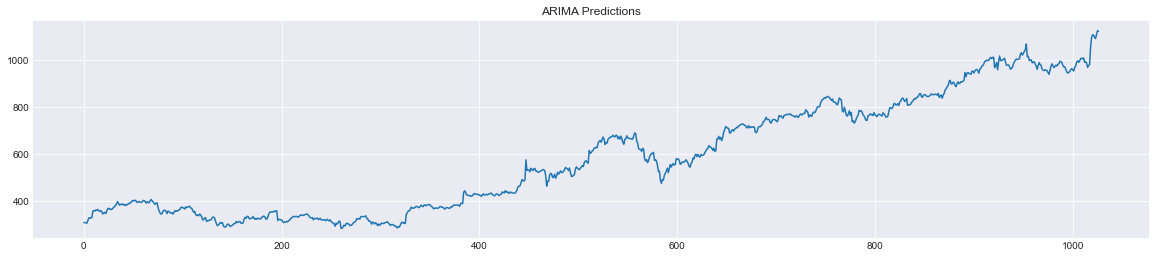

In [36]:
plt.figure(figsize = (20, 4))
predictions = model_fit.predict(exog = X_test, typ = "levels")
plt.title("ARIMA Predictions")
plt.plot(predictions)
plt.show()

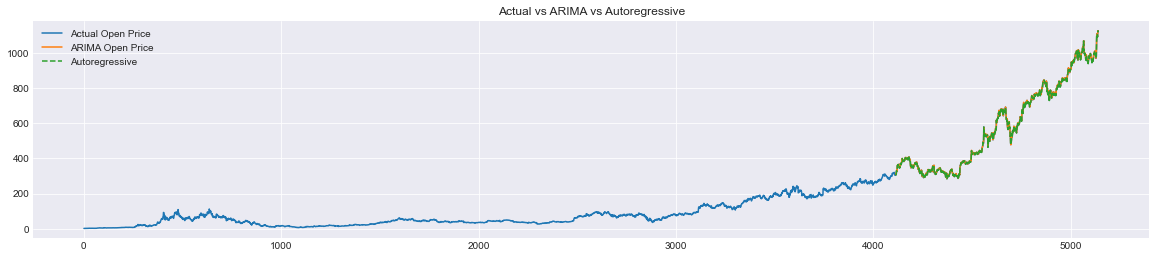

In [37]:
plt.figure(figsize = (20, 4))
plt.plot(np.append(y_train, y_test), label = "Actual Open Price")
plt.plot(np.append(np.array([None] * len(y_train)), predictions), label = "ARIMA Open Price")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Autoregressive")
plt.title("Actual vs ARIMA vs Autoregressive")
plt.legend()
plt.show()

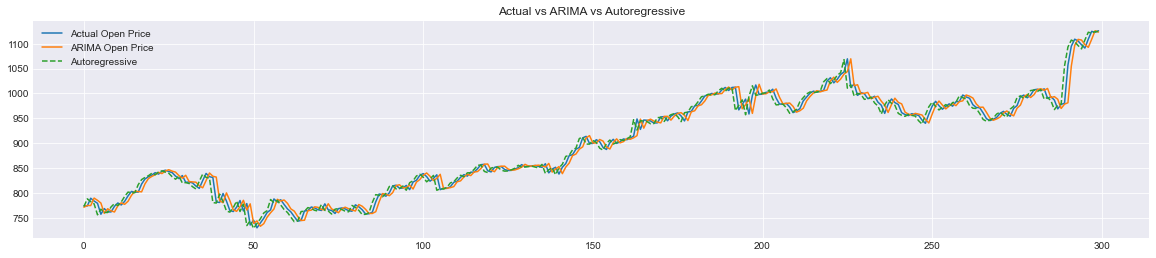

In [38]:
plt.figure(figsize = (20, 4))
plt.plot(y_test[-300:], label = "Actual Open Price")
plt.plot(predictions[-300:], label = "ARIMA Open Price")
plt.plot(y_pred[-300:], "--", label = "Autoregressive")
plt.title("Actual vs ARIMA vs Autoregressive")
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
mean_squared_error(y_test, y_pred)

110.47318283370424

In [41]:
np.sqrt(mean_squared_error(y_test, y_pred))

10.51062238089183

## **GROWTH FORECAST**

In [42]:
ts_pred = df.copy()
ts_pred["Growth"] = ts_pred["Open"].pct_change()
ts_pred["Next"] = ts_pred["Growth"].shift()
ts_pred = ts_pred.dropna()

In [43]:
X = ts_pred["Growth"].values
y = ts_pred["Next"].values

In [44]:
train_size = int(len(X) * 0.8)

In [45]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [46]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
lr.coef_

array([-0.0637083])

In [50]:
y_pred = lr.predict(X_test)

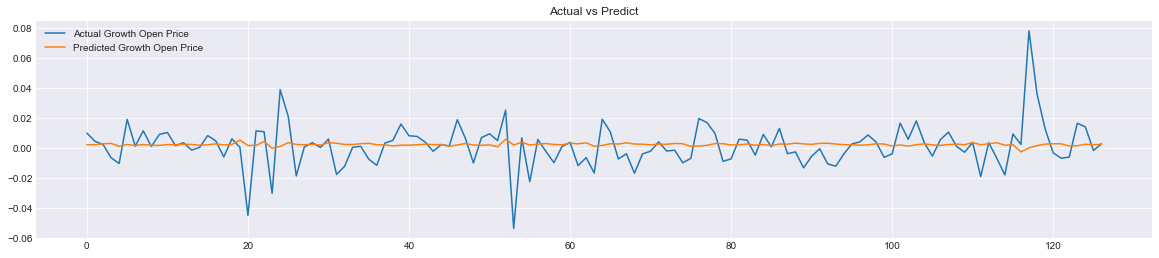

In [51]:
plt.figure(figsize = (20, 4))
plt.plot(y_test[-127:], label = "Actual Growth Open Price")
plt.plot(y_pred[-127:], label = "Predicted Growth Open Price")
plt.title("Actual vs Predict")
plt.legend()
plt.show()

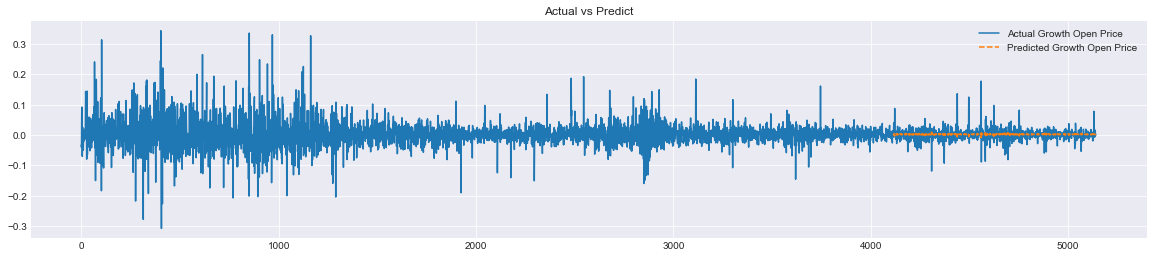

In [52]:
plt.figure(figsize = (20, 4))
plt.plot(np.append(y_train, y_test), label = "Actual Growth Open Price")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Predicted Growth Open Price")
plt.title("Actual vs Predict")
plt.legend()
plt.show()

In [53]:
model = ARIMA(y_test, order = (1, 0, 1))

In [54]:
model_fit = model.fit(disp = 5)

In [55]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1028
Model:                     ARMA(1, 1)   Log Likelihood                2609.431
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 27 Aug 2020   AIC                          -5210.862
Time:                        22:44:35   BIC                          -5191.121
Sample:                             0   HQIC                         -5203.369
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.467      0.014       0.000       0.003
ar.L1.y       -0.9607      0.043    -22.330      0.000      -1.045      -0.876
ma.L1.y        0.9394      0.053     17.565      0.0

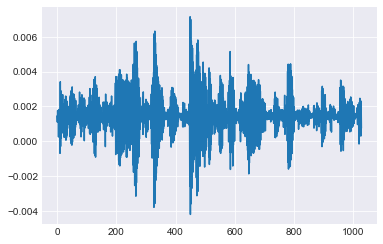

In [56]:
predictions = model_fit.predict(exog = X_test, typ = "levels")
plt.plot(predictions)
plt.show()

In [57]:
len(predictions)

1028

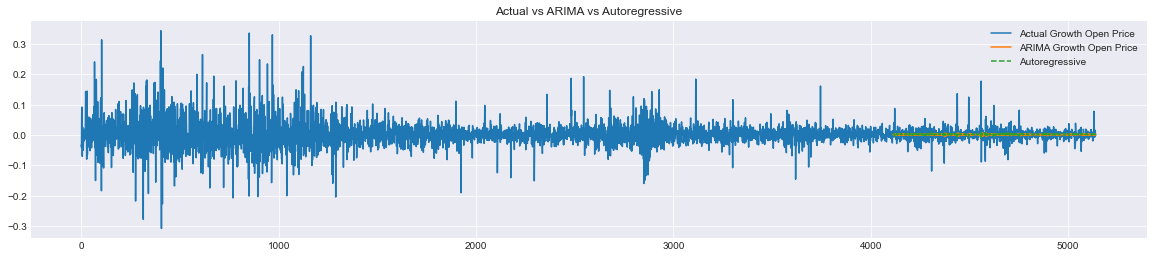

In [58]:
plt.figure(figsize = (20, 4))
plt.plot(np.append(y_train, y_test), label = "Actual Growth Open Price")
plt.plot(np.append(np.array([None] * len(y_train)), predictions), label = "ARIMA Growth Open Price")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Autoregressive")
plt.title("Actual vs ARIMA vs Autoregressive")
plt.legend()
plt.show()

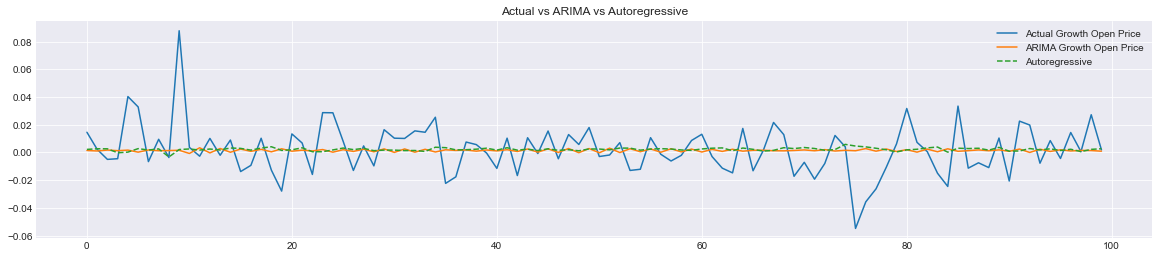

In [59]:
plt.figure(figsize = (20, 4))
plt.plot(y_test[:100], label = "Actual Growth Open Price")
plt.plot(predictions[:100], label = "ARIMA Growth Open Price")
plt.plot(y_pred[:100], "--", label = "Autoregressive")
plt.title("Actual vs ARIMA vs Autoregressive")
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error

In [61]:
mean_squared_error(y_test, y_pred)

0.00036717788667597944

In [62]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.019161886302657666